## Train data generation

### Function : positionate the array of microphones

In [11]:
def center_to_mics(center):
    x_center = center[0]
    y_center = center[1]
    if(center.shape[0]==3):
        z_center = center[2]
        
    mic0_x = x_center + 0.015
    mic0_y = y_center
    mic1_x = x_center - 0.015
    mic1_y = y_center
    mic2_x = x_center + 0.045
    mic2_y = y_center + 0.015
    mic3_x = x_center + 0.045
    mic3_y = y_center - 0.015
    mic4_x = x_center - 0.045
    mic4_y = y_center + 0.015
    mic5_x = x_center - 0.045
    mic5_y = y_center - 0.015
    
    
    if(center.shape[0]==3):
        pos = np.array([[mic0_x, mic1_x, mic2_x, mic3_x, mic4_x, mic5_x],
                          [mic0_y, mic1_y, mic2_y, mic3_y, mic4_y, mic5_y],
                             [z_center, z_center, z_center, z_center, z_center, z_center]])
        
    else:
        pos = np.array([[mic0_x, mic1_x, mic2_x, mic3_x, mic4_x, mic5_x],
                          [mic0_y, mic1_y, mic2_y, mic3_y, mic4_y, mic5_y]])
    return pos
    
    

### Function : calculate angle between source and microphone

In [12]:
def angle_to_pos(position, distance, angle):
    
    rad_ang = np.deg2rad(angle)
    
    pos_x = position[0] + distance * np.cos(rad_ang)
    pos_y = position[1] + distance * np.sin(rad_ang)
    
    
    pos_x = float(pos_x)
    pos_y = float(pos_y)
    
    # round the positions to only 3 decimals 
    pos_x = round(pos_x, 3)
    pos_y = round(pos_y, 3)
    
    pos = np.array([pos_x, pos_y])
    return pos

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra

(97, 3800)
data generated = 14.29%
(193, 3800)
data generated = 28.57%
(289, 3800)
data generated = 42.86%
(385, 3800)
data generated = 57.14%
(481, 3800)
data generated = 71.43%
(577, 3800)
data generated = 85.71%


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(673, 3800)
data generated = 100.00%


(-4, 10)

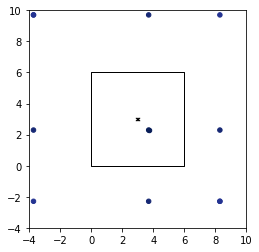

In [20]:
hrir_test = np.zeros((160,180,6))
hrir_test[0,:,:] = 1
path_lego = '../data/lego1_h_theta_time.npy' #  path to lego mics data 
hrir_lego  = np.load(path_lego) 
shape = 3800

distance1 = np.array([2])
distance2 = np.array([1])

# discretization is 12, 24, or 45
discretization = 45 
angles = np.arange(360, step=discretization)

corners_train1 = np.array([[0,0], [0,6], [6,6], [6,0]]).T  # [x,y]
max_order = 10
room_train1 = pra.Room.from_corners(corners_train1, fs=8000, max_order=max_order, absorption=0.35)

# 7 positions of the setup in the room
centers = np.array([[2.1,2.1], [2.1,3.9], [3.9,2.1], [3.9,3.9], [3.,2.1], [3.,3.9], [3.,3.]])

#initialize the matrix of rirs don't forget the labels
train_data1 = np.array([np.zeros(3800)])

#total number of data for room1
total = centers.shape[0] * angles.shape[0] * 2 * 6 # 7pos * num angles * 2 distances * 6mics

for c,center in enumerate(centers):
    
    R = center_to_mics(center)
    mic = pra.MicrophoneArrayHrtf(R, room_train1.fs, hrir_test)
    for a,angle in enumerate(angles):
        for distance in(distance1, distance2):
        
            s = angle_to_pos(center, distance, angle)
            room_train1 = pra.Room.from_corners(corners_train1, fs=8000, max_order=max_order, absorption=0.35)
            room_train1.add_microphone_array(mic)
            room_train1.add_source(s)

            # compute image sources
            room_train1.image_source_model(use_libroom=True)
            room_train1.compute_rir_hrtf()


            # store the data 
            rir0 = room_train1.rir[0][0]
            rir1 = room_train1.rir[1][0]
            rir2 = room_train1.rir[2][0]
            rir3 = room_train1.rir[3][0]
            rir4 = room_train1.rir[4][0]
            rir5 = room_train1.rir[5][0]
            
            zero0 = np.zeros(shape - rir0.shape[0])
            zero1 = np.zeros(shape - rir1.shape[0])
            zero2 = np.zeros(shape - rir2.shape[0])
            zero3 = np.zeros(shape - rir3.shape[0])
            zero4 = np.zeros(shape - rir4.shape[0])
            zero5 = np.zeros(shape - rir5.shape[0])

            rir0 = np.array([np.concatenate((rir0, zero0), axis=None)])
            rir1 = np.array([np.concatenate((rir1, zero1), axis=None)])
            rir2 = np.array([np.concatenate((rir2, zero2), axis=None)])
            rir3 = np.array([np.concatenate((rir3, zero3), axis=None)])
            rir4 = np.array([np.concatenate((rir4, zero4), axis=None)])
            rir5 = np.array([np.concatenate((rir5, zero5), axis=None)])          

            train_data1 = np.concatenate((train_data1, rir0, rir1, rir2, rir3, rir4, rir5), axis=0)
            
    percentage = ((train_data1.shape[0]-1)/total) *100
    print('data generated = {:0.2f}%'.format(percentage))
    
train_data1 = train_data1[1:,:]
print('finished generation')

fig, ax = room_train1.plot(img_order=2)
ax.set_xlim([-5, 10])
ax.set_ylim([-5, 10])

data generated = 14.29%
data generated = 28.57%
data generated = 42.86%
data generated = 57.14%
data generated = 71.43%
data generated = 85.71%


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


data generated = 100.00%
finished generation


(-5, 10)

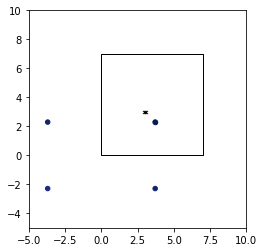

In [17]:
hrir_test = np.zeros((160,180,6))
hrir_test[0,:,:] = 1
path_lego = '../data/lego1_h_theta_time.npy' #  path to lego mics data 
hrir_lego  = np.load(path_lego) 
shape = 3800

distance1 = np.array([2])
distance2 = np.array([1])
discretization = 45
angles = np.arange(360, step=discretization)


corners_train2 = np.array([[0,0], [0,7], [7,7], [7,0]]).T  # [x,y]
max_order = 10

room_train2 = pra.Room.from_corners(corners_train2, fs=8000, max_order=max_order, absorption=0.25) 

# 7 random positions of the setup in the room
centers = np.array([[2.1,2.1], [2.1,3.9], [3.9,2.1], [3.9,3.9], [3.,2.1], [3.,3.9], [3.,3.]])

#initialize the matrix of rirs don't forget the labels
train_data2 = np.array([np.zeros(3800)])

#total number of data for room2
total = centers.shape[0] * angles.shape[0] * 2 * 6 # 7pos * num angles * 2 distances * 6mics

for c,center in enumerate(centers):
    
    R = center_to_mics(center)
    mic = pra.MicrophoneArrayHrtf(R, room_train2.fs, hrir_test)
    #room_train2.add_microphone_array(mic)
    for a,angle in enumerate(angles):
        for distance in(distance1, distance2):
        
            s = angle_to_pos(center, distance, angle)
            room_train2 = pra.Room.from_corners(corners_train2, fs=8000, max_order=max_order, absorption=0.25) #0.55
            room_train2.add_microphone_array(mic)
            room_train2.add_source(s)

            # compute image sources
            room_train2.image_source_model(use_libroom=True)
            room_train2.compute_rir_hrtf()


            # store the data 
            rir0 = room_train2.rir[0][0]
            rir1 = room_train2.rir[1][0]
            rir2 = room_train2.rir[2][0]
            rir3 = room_train2.rir[3][0]
            rir4 = room_train2.rir[4][0]
            rir5 = room_train2.rir[5][0]

            zero0 = np.zeros(shape - rir0.shape[0])
            zero1 = np.zeros(shape - rir1.shape[0])
            zero2 = np.zeros(shape - rir2.shape[0])
            zero3 = np.zeros(shape - rir3.shape[0])
            zero4 = np.zeros(shape - rir4.shape[0])
            zero5 = np.zeros(shape - rir5.shape[0])

            rir0 = np.array([np.concatenate((rir0, zero0), axis=None)])
            rir1 = np.array([np.concatenate((rir1, zero1), axis=None)])
            rir2 = np.array([np.concatenate((rir2, zero2), axis=None)])
            rir3 = np.array([np.concatenate((rir3, zero3), axis=None)])
            rir4 = np.array([np.concatenate((rir4, zero4), axis=None)])
            rir5 = np.array([np.concatenate((rir5, zero5), axis=None)])

            train_data2 = np.concatenate((train_data2, rir0, rir1, rir2, rir3, rir4, rir5), axis=0)
            
        
    percentage = ((train_data2.shape[0]-1)/total) *100
    print('data generated = {:0.2f}%'.format(percentage))
    

train_data2 = train_data2[1:,:]
print('finished generation')

fig, ax = room_train2.plot(img_order=2)
ax.set_xlim([-5, 10])
ax.set_ylim([-5, 10])

In [ ]:
train_loader = np.concatenate((train_data1, train_data2), axis=0)

In [ ]:
# 8 class be
np.save('train_loader_8class', train_loader )